# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Automatic differentiation
## Chapter : Dense automatic differentiation, and geodesic shooting

This notebook illustrates automatic differentiation, with an application to Hamilton's equations and geodesic shooting. More precisely, we use automatic differentiation with the following combination of properties:
* *First* and *Second* order. The variables used encode gradient and (sometimes) hessian information.
* *Dense*. The Taylor expansion information - gradient and hessian - is stored in dense (full) form. This is practical for functions with arbitrary complexity, but low dimensional input.
* *Forward*. The Taylor expansion information is propagated forward along with the computations.

**Known bugs and incompatibilities.** Our implementation of automatic differentiation is based on subclassing the numpy array class. While simple and powerful, this approach suffers from a few pitfalls, described in the notebook [ADBugs](ADBugs.ipynb).

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. A word on Hamilton's equations](#1.-A-word-on-Hamilton's-equations)
    * [1.1 Optics and geodesics](#1.1-Optics-and-geodesics)
    * [1.2 Celestial mechanics](#1.2-Celestial-mechanics)
    * [1.3 The Lotka-Voltera Predator-Prey model](#1.3-The-Lotka-Voltera-Predator-Prey-model)
  * [2. Automatic differentiation basics](#2.-Automatic-differentiation-basics)
    * [2.1 Differentiating a function](#2.1-Differentiating-a-function)
    * [2.2 Differentiating w.r.t several variables](#2.2-Differentiating-w.r.t-several-variables)
    * [2.3 Vectorization](#2.3-Vectorization)
    * [2.4 Second order automatic differentiation](#2.4-Second-order-automatic-differentiation)
  * [3. Solving ordinary differential equations](#3.-Solving-ordinary-differential-equations)
    * [3.1 Explicit Euler scheme](#3.1-Explicit-Euler-scheme)
    * [3.2 High order explicit schemes](#3.2-High-order-explicit-schemes)
    * [3.3 Symplectic Euler scheme - Separable case](#3.3-Symplectic-Euler-scheme---Separable-case)
    * [3.4 Symplectic Verlet scheme - Separable case](#3.4-Symplectic-Verlet-scheme---Separable-case)
    * [3.5 Symplectic Euler scheme - Non separable case](#3.5-Symplectic-Euler-scheme---Non-separable-case)
  * [4. Shooting geodesics](#4.-Shooting-geodesics)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow importing agd from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Dense','Algo'))

In [2]:
from agd import AutomaticDifferentiation as ad

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def reload_packages():
    import importlib
    ad = importlib.reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()

## 1. A word on Hamilton's equations

We choose to illustrate the automatic differentiation concept using Hamilton's equations of geodesics, which read
$$
    \dot q = \partial_p H(q,p), \qquad \dot p = -\partial_q H(q,p),
$$
where $H$ is the *Hamiltonian* of the medium. 
These equations are (extremely) common in optics and mechanics. They naturally involve first-order differentiation. In addition, higher order differentiation will also be necessary in the context of geodesic shooting (adjusting the initial conditions to meet a prescribed endpoint), or implicit schemes.

### 1.1 Optics and geodesics

Hamilton's equations characterize extremal paths, known as geodesics, arising in optics.
Following the classical convention we denote by 
* $q$ the position variable,
* $p$ the impultion, which is dual to the velocity.

**Riemannian Hamiltonian.** For a domain $\Omega \subset R^d$ equipped with a Riemannian metric $M : \Omega \to S_d^{++}$, the Hamiltonian is defined as 
$$
    H(q,p) := \frac 1 2 \|p\|_{D(q)}^2, \quad \text{where} D(q) := M(q)^{-1}.
$$

**Poincaré's half plane model.** 
We illustrate this ODE in the case of Poincaré's half plane model of the hyperbolic space, defined by the Riemannian metric
$$
    M(q) := \frac{\rm Id}{q_1^2},
$$
where $q = (q_0,q_1) \in \Omega = R \times R^{++}$. Thus $H(q,p) = (q_1^2/2) \|p\|^2$. 

**Exponential map.**
We also consider the Riemannian metric on $R^2 \setminus \{0\}$ defined by
$$
    M(q) := \frac{\rm Id}{q^2}.
$$
It can be regarded as the metric induced by the logarithmic (multivalued) map $\ln : C \setminus \{0\} \to C$, where the targer space $C$ is equipped with the usual norm, and it possesses periodic trajectories.


**Note on the `ad.toarray` function.** The presence of this function is required due to a (rather rare) incompatibility between numpy scalars and ad array scalars, see the notebook [ADBugs](ADBugs.ipynb).

In [5]:
def SquaredNorm(p):
    return (p**2).sum(axis=0)
def H_HalfPlane(q,p):
    return ad.toarray(0.5*q[1]**2)*SquaredNorm(p)
def H_Log(q,p):
    return ad.toarray(0.5*SquaredNorm(q))*SquaredNorm(p)

### 1.2 Celestial mechanics

The Hamiltonian is in this case the sum of the kinetic energy, and of the potential energy, say w.r.t. a mass at the origin.

<!---
**Symplectic integrators**
In this notebook, we solve the equations of geodesics using a standard Runge-Kutta scheme. This may sound as a heresy since these equations benefit from a Hamiltonian structure, and can thus be solved more stably using a symplectic integrator, in principle. However, our Hamiltonians are *non-separable*, in other words they do *not* take the form 
$$
    H(q,p) = F(p) + V(q).
$$
For this reason, the implementation details of a symplectic scheme are non-trivial, and we thus stick to a standard ODE scheme.
--->

In [6]:
def H_Celestial(q,p):
    return ad.toarray(0.5*SquaredNorm(p)) - SquaredNorm(q)**-0.5

### 1.3 The Lotka-Voltera Predator-Prey model

Some models in appeareance unrelated with mechanics or optics also exhibit a Hamiltonian structure. This is the case of the Lotka-Voltera Predator-Prey model.
Using a logarithmic change of variables, this model can be put in Hamiltonian form.

In [7]:
def H_LK(q,p,params=(1.,1.,1.,1.)):
    alpha,beta,gamma,delta=params
    return ad.toarray(beta*np.exp(y)-alpha*y) + gamma*np.exp(x)-delta*x

## 2. Automatic differentiation basics

We illustrate the automatic differentiation mechanism by differentiating a Hamiltonian w.r.t. the position $q$ and momentum $p$, which is a prerequisite for implementing Hamilton's ODE of motion.

### 2.1 Differentiating a function

In [8]:
Hamiltonian = H_HalfPlane

In [9]:
q = np.array([0.,1.])
p = np.array([1.,1.])

In [10]:
Hamiltonian(q,p)

1.0

In order access the Hamiltonian's derivatives, say with respect to position, we evaluate it on a variable featuring first order information. Said otherwise, we create a variable representing the first order Taylor expansion
$$
    q_{\rm ad} = (q_0+\delta_0,q_1+\delta_1) + O(\|\delta\|^2),
$$
where $\delta = (\delta_0,\delta_1)$ is a symbolic, infinitesimal perturbation.

In [11]:
q_ad = ad.Dense.identity(constant=q)

In [12]:
q_ad # Contains an additional array representing first order information.

denseAD(array([0., 1.]),
array([[1., 0.],
       [0., 1.]]))

In [13]:
print("Zero-th order : ",q_ad.value)
print("First order : \n",q_ad.coef)

Zero-th order :  [0. 1.]
First order : 
 [[1. 0.]
 [0. 1.]]


The first order information is propagated through the computations, and eventually we obtain the result
$$
    H(q_{\rm ad},p) = H(q,p) + <\nabla_q H(q,p),\delta> + O(\|\delta\|^2).
$$
Note that, for Poincaré's half plane model, one has $\nabla_q H(q,p) = (0,q_1 \|p\|^2)$.

In [14]:
Hamiltonian(q_ad,p)

denseAD(array(1.),array([0., 2.]))

In [15]:
print("Gradient of the Hamiltonian w.r.t. the variable q : ",Hamiltonian(q_ad,p).coef)

Gradient of the Hamiltonian w.r.t. the variable q :  [0. 2.]


We can similarly differentiate w.r.t. the momentum $p$. Poincaré's half plane model obeys
$\nabla_p H(q,p) = q_1^2 p$.

In [16]:
p_ad = ad.Dense.identity(constant=p)
Hamiltonian(q,p_ad)

denseAD(array(1.),array([1., 1.]))

### 2.2 Differentiating w.r.t several variables

Evaluating $H(q_{\rm ad},p_{\rm ad})$ yields an result may sound unexpected: we obtain the sum $\nabla_q H(q,p)+\nabla_p H(q,p)$ of the gradients, instead of their independent values. Indeed, this follows from the first order Taylor expansion
$$
H(q+\delta,p+\delta) = 
H(q,p) + <\nabla_q H(q,p),\delta> + <\nabla_p H(q,p),\delta> + O(\|\delta\|^2),
$$
where $\delta = (\delta_0,\delta_1)$ is an infinitesimal symbolic perturbation.

In [17]:
Hamiltonian(q_ad,p_ad)

denseAD(array(1.),array([1., 3.]))

In order to obtain the gradient of $H$ w.r.t the independent variables $q$ and $p$, we need to specify that the corresdponding infinitesimal perturbations are independent. Namely set
$$
    q_{\rm ad} = q+(\delta_0,\delta_1), \quad p_{\rm ad} = p+(\delta_2,\delta_3),
$$
where $(\delta_0,\cdots,\delta_4)$ is four dimensional infinitesimal perturbation.

In [18]:
q_ad = ad.Dense.identity(constant=q,shift=(0,p.size))
p_ad = ad.Dense.identity(constant=p,shift=(q.size,0))

As desired, we obtain the full gradient of $H$, which is the concatenation of $\nabla_q H$ and $\nabla_p H$.

In [19]:
Hamiltonian(q_ad,p_ad)

denseAD(array(1.),array([0., 2., 1., 1.]))

In [20]:
q_ad

denseAD(array([0., 1.]),
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]]))

In [21]:
p_ad

denseAD(array([1., 1.]),
array([[0., 0., 1., 0.],
       [0., 0., 0., 1.]]))

### 2.3 Vectorization

A common programming style in Python application to numerics is vectorized computations using numpy tensors.
This allows avoiding loops, when some operation has to be repeated a large number of times, with improvements in clarity, flexibility, and speed. 

As an example, we compute $H(q_0,p_0)$, $H(q_1,p_1)$, $H(q_2,p_2)$, where $q_0,q_1,q_2$ and $p_0,p_1,p_2$ are different positions and impulsions. We also differentiate these values w.r.t. the impulsion.

In [22]:
q0 = np.array([0.,1.]); q1 = np.array([1.,1.]); q2 = np.array([-2.,1.]); 
p0 = np.array([1.,1.]); p1 = np.array([1.,0.]); p2 = np.array([-1.,-1.]); 

In [23]:
Hamiltonian(q0,p0), Hamiltonian(q1,p1), Hamiltonian(q2,p2) 

(1.0, 0.5, 1.0)

In [24]:
Ham_seq = [Hamiltonian(q,ad.Dense.identity(constant=p)) for (q,p) in ((q0,p0), (q1,p1), (q2,p2))]
Ham_seq

[denseAD(array(1.),array([1., 1.])),
 denseAD(array(0.5),array([1., 0.])),
 denseAD(array(1.),array([-1., -1.]))]

The vectorized form of these computations is as follows.

In [25]:
q_vec = np.stack( (q0,q1,q2),axis=1)
p_vec = np.stack( (p0,p1,p2),axis=1)

In [26]:
Hamiltonian(q_vec,p_vec)

array([1. , 0.5, 1. ])

In [27]:
p_vec_ad = ad.Dense.identity(constant=p_vec)

However, the automatic differentiation result may not be what is desired. Indeed, the entries of `q_vec` are all considered independent, and we recover a six dimensional gradient vector for each component. This is both impractical and numerically expensive.

In [28]:
Ham_vec = Hamiltonian(q_vec,p_vec_ad)
Ham_vec

denseAD(array([1. , 0.5, 1. ]),
array([[ 1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0., -1.]]))

In [29]:
print("Sequential result : ",Ham_seq[0])
print("Vectorized result : ",Ham_vec[0])

Sequential result :  denseAD(1.0,[1. 1.])
Vectorized result :  denseAD(1.0,[1. 0. 0. 1. 0. 0.])


In this situation, and in contrast with the previous section, we would like the perturbations to be regarded as dependent. This is achieved with the following parameters:
* `shape_free` : apply free independent symbolic perturbations w.r.t. these dimensions.
* `shape_bound` : apply bound correlated symbolic perturbations w.r.t. these dimensions.

It is assumed that the *free* dimensions come first, and the *bound* dimensions come last. Only one of the two parameters `shape_free` and `shape_bound` needs to be specified, since they are redundant.

In [30]:
p_vec.shape

(2, 3)

The first dimension is *free*, and the last one is *bound* since it is only introduced for vectorization purposes.

In [31]:
shape_free,shape_bound = p_vec.shape[:1], p_vec.shape[-1:]

In [32]:
p_vec_ad = ad.Dense.identity(constant=p_vec, shape_bound=shape_bound)
#p_vec_ad = ad.Dense.identity(constant=p_vec, shape_free=shape_free) # Equivalently

In [33]:
Ham_vec = Hamiltonian(q_vec,p_vec_ad)
Ham_vec

denseAD(array([1. , 0.5, 1. ]),
array([[ 1.,  1.],
       [ 1.,  0.],
       [-1., -1.]]))

In [34]:
print("Vectorized result (with shape_bound): ",Ham_vec[0])

Vectorized result (with shape_bound):  denseAD(1.0,[1. 1.])


This technique is compatible with differentiation w.r.t. multiple independent variables.

In [35]:
q_vec_ad = ad.Dense.identity(constant=q_vec, shape_free=shape_free, shift=(0,len(p_vec)) )
p_vec_ad = ad.Dense.identity(constant=p_vec, shape_free=shape_free, shift=(len(q_vec),0) )

In [36]:
Ham_vec = Hamiltonian(q_vec_ad,p_vec_ad)
Ham_vec

denseAD(array([1. , 0.5, 1. ]),
array([[ 0.,  2.,  1.,  1.],
       [ 0.,  1.,  1.,  0.],
       [ 0.,  2., -1., -1.]]))

In [37]:
print("Full gradient w.r.t q0,p0 : ", Ham_vec[0])

Full gradient w.r.t q0,p0 :  denseAD(1.0,[0. 2. 1. 1.])


**Alternative implementation using arrays of arrays.** Another way to achieve vectorization is to use 'arrays of arrays'. This approach is not recommended here, since it is more cumbersome and less efficient, but it is still shown for completeness and testing.

In [48]:
q_diss = ad.disassociate(q_vec, shape_free=(2,), # Creates an array of arrays
                         expand_free_dims=None, expand_bound_dims=None) 

In [49]:
print("An array of arrays :", q_diss)
print("First element :", q_diss[0])

An array of arrays : [array([ 0.,  1., -2.]) array([1., 1., 1.])]
First element : [ 0.  1. -2.]


It is safer to avoid scalar arrays in the context of 'arrays of arrays'. Indeed, confusion aries otherwise between 'arrays scalars with array components', and 'standard arrays'. The default for `ad.disassociate` is to introduce singleton dimensions to ensure this behavior is avoided.

In [50]:
q_diss = ad.disassociate(q_vec, shape_free=(2,)) 
p_diss = ad.disassociate(p_vec, shape_free=(2,))

In [51]:
print("Disassociated array ", q_diss)
print("with type ", type(q_diss), "with data type ", q_diss.dtype, 
      "and shape ", q_diss.shape, "including a trailing singleton.")
print("Reconstructed array", ad.associate(q_diss)) # Inverse operation to disassociate

Disassociated array  [[array([[ 0.],
       [ 1.],
       [-2.]])]
 [array([[1.],
       [1.],
       [1.]])]]
with type  <class 'numpy.ndarray'> with data type  object and shape  (2, 1) including a trailing singleton.
Reconstructed array [[ 0.  1. -2.]
 [ 1.  1.  1.]]


We can now manipulate `q_diss` and `p_diss` as standard low-dimensional arrays, abstracting the underlying vectorization, and in particular use the AD tools.

In [52]:
Hamiltonian(q_diss,p_diss)

array([array([[1. ],
       [0.5],
       [1. ]])], dtype=object)

In [53]:
q_diss_ad = ad.Dense.identity(constant=q_diss,shift=(0,2))
p_diss_ad = ad.Dense.identity(constant=p_diss,shift=(2,0))

In [54]:
Ham_diss_ad = Hamiltonian(q_diss_ad,p_diss_ad)

In [55]:
ad.associate(Ham_diss_ad)

denseAD(array([1. , 0.5, 1. ]),
array([[ 0.,  2.,  1.,  1.],
       [ 0.,  1.,  1.,  0.],
       [ 0.,  2., -1., -1.]]))

### 2.4 Second order automatic differentiation

There are situations where second order automatic differentiation is needed. It could be achieved, in principle, by recursive calls to first order differentiation. However, for reasons of performance and convenience, a dedicated class is implemented.

In [49]:
q_ad = ad.Dense2.identity(constant=q)

The hessian of Poincaré's half plane model hamiltonian, w.r.t. position is 
$$
    \nabla_q H(q,p) = \begin{pmatrix} 0 & 0 \\ 0 & \|p\|^2 \end{pmatrix}
$$
and w.r.t. impulsion
$$
    \nabla_p H(q,p) = q_0^2 {\rm Id}.
$$

In [50]:
Ham = Hamiltonian(q_ad,p)
Ham

denseAD2(array(1.),array([0., 2.]),
array([[0., 0.],
       [0., 2.]]))

In [51]:
print("Function value : ", Ham.value)
print("Gradient : ", Ham.coef1)
print("Hessian : \n", Ham.coef2)

Function value :  1.0
Gradient :  [0. 2.]
Hessian : 
 [[0. 0.]
 [0. 2.]]


In [52]:
p_ad = ad.Dense2.identity(constant=p)

In [53]:
Hamiltonian(q,p_ad)

denseAD2(array(1.),array([1., 1.]),
array([[1., 0.],
       [0., 1.]]))

A joint hessian, of size $4\times 4$, can be computed. 

In [54]:
q_ad = ad.Dense2.identity(constant=q, shift=(0,p.size))
p_ad = ad.Dense2.identity(constant=p, shift=(q.size,0))

In [55]:
p_ad.coef2.shape

(2, 4, 4)

In [56]:
Hamiltonian(q_ad,p_ad)

denseAD2(array(1.),array([0., 2., 1., 1.]),
array([[0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 2., 1., 0.],
       [0., 2., 0., 1.]]))

Vectorization works as in the first order case.

In [57]:
q_vec_ad = ad.Dense2.identity(constant=q_vec, shape_free=shape_free)

In [58]:
Ham = Hamiltonian(q_vec_ad,p_vec)
Ham[0]

denseAD2(array(1.),array([0., 2.]),
array([[0., 0.],
       [0., 2.]]))

In [59]:
q_vec_ad = ad.Dense2.identity(constant=q_vec,shape_bound=shape_bound, shift=(0,len(p_vec)) )
p_vec_ad = ad.Dense2.identity(constant=p_vec,shape_bound=shape_bound, shift=(len(q_vec),0) )

In [60]:
Ham = Hamiltonian(q_vec_ad,p_vec_ad)
Ham[0]

denseAD2(array(1.),array([0., 2., 1., 1.]),
array([[0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 2., 1., 0.],
       [0., 2., 0., 1.]]))

**Alternative approach using recursive automatic differentiation.** 
We present an alternative approach to second order automatic differentiation, based on recursive first order differentiation. It is not recommended, since it is more cumbersome and less efficient, but it is still shown for completeness and testing.

<!---We can reconstruct the second order AD information by associating two levels of first order differentiation.
Note the parameter `singleton_axis=-2`, replacing the default `singleton_axis=-1`, because the last axis is for the AD dimension.--->

In [61]:
def ADRecIdentity(constant,shape_free=None,shift=(0,0)):
    # First order differentiation
    q_ad = ad.Dense.identity(constant=constant, shape_free=shape_free, shift=shift) 
    # Hide automatic differentiation info in the component type
    q_diss = ad.disassociate(q_ad, shape_free=shape_free) 
    # Recursive first order differentiation
    q_ad2 = ad.Dense.identity(constant=q_diss, shape_free=shape_free, shift=shift) 
    return q_ad2

def ADRecToAD2(q): 
    q01 = ad.associate(q.value) # Zero-th and first order
    q12 = ad.associate(q.coef,squeeze_free_dims=-2) # first and second order
    q12 = np.moveaxis(q12,q.ndim-1,-1) # Put ad information last
    return ad.Dense2.denseAD2(q01.value,q01.coef,q12.coef)

In [62]:
q_rec = ADRecIdentity(q,shape_free=(2,), shift=(0,2))
p_rec = ADRecIdentity(p,shape_free=(2,), shift=(2,0))

In [63]:
Ham_rec = Hamiltonian(q_rec,p_rec)
ADRecToAD2(Ham_rec)

denseAD2(array(1.),array([0., 2., 1., 1.]),
array([[0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 2., 1., 0.],
       [0., 2., 0., 1.]]))

In [64]:
q_vec_rec = ADRecIdentity(q_vec, shape_free=(2,), shift=(0,2))
p_vec_rec = ADRecIdentity(p_vec, shape_free=(2,), shift=(2,0))

In [65]:
Ham_vec_rec = Hamiltonian(q_vec_rec,p_vec_rec)
ADRecToAD2(Ham_vec_rec)[0]

denseAD2(array(1.),array([0., 2., 1., 1.]),
array([[0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 2., 1., 0.],
       [0., 2., 0., 1.]]))

## 3. Solving ordinary differential equations

We implement Hamilton's equations of motion
$$
    \dot q = \partial_p H(q,p), \qquad \dot p = -\partial_q H(q,p),
$$
using several numerical schemes. In terms of automatic differentiation, the most interesting case is the semi-implicit Symplectic Euler scheme.

**Conserved quantity.**
By construction, the Hamiltonian value is conserved along the Hamiltonian flow:
$$
    H(q(t),p(t)) = {\rm cst},
$$
if $t \mapsto (q(t),p(t))$ is a solution to Hamilton's equations of motion.

**Explicit solution for the half plane model.**
The geodesics for the Poincare half plane model are known explicitly. They are half circles whose center lies on the horizontal axis.

### 3.1 Explicit Euler scheme

The simplest of all ODE solvers reads
$$
    \frac{q_{n+1}-q_n} {\Delta t} = \partial_p H(q_n,p_n), \qquad \frac{p_{n+1}-p_n} {\Delta t} = -\partial_q H(q_n,p_n),
$$
where $(q_0,p_0)$ is a given initial condition, and $n>0$ is the iteration number, and $\Delta t$ is the time step.

In [66]:
def EulerStep(q,p,H,dt):
    d=len(q)
    q_ad = ad.Dense.identity(constant=q,shape_free=(d,),shift=(0,d))
    p_ad = ad.Dense.identity(constant=p,shape_free=(d,),shift=(d,0))
    grad = np.moveaxis(H(q_ad,p_ad).coef,-1,0)
    return q+dt*grad[d:],p-dt*grad[:d]

def Geodesic(q0,p0,H,t,n=100,step=EulerStep):
    dt=t/n
    q,p=q0.copy(),p0.copy()
    Q,P=[q],[p]
    for i in range(n):
        q,p=step(q,p,H,dt)
        Q.append(q)
        P.append(p)
    return ad.stack(Q,axis=-1),ad.stack(P,axis=-1),np.linspace(0,t,n+1)

In [67]:
grad = EulerStep(q_vec,p_vec,Hamiltonian,0.1)

Euler's explicit scheme is only first order accurate. While the geodesic circular shape is more or less observed, the Hamiltonian conservation is far from perfect.

In [68]:
Q,P,T = Geodesic(q_vec,p_vec,Hamiltonian,4.)
# For convenience, we put time as a second coordinate.
Q,P = [np.moveaxis(arr,-1,1) for arr in (Q,P)] 

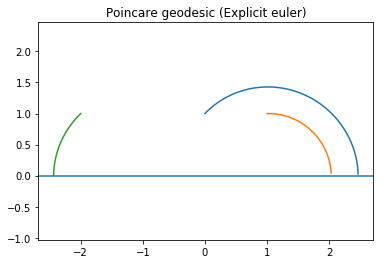

In [69]:
plt.axis('equal'); plt.title("Poincare geodesic (Explicit euler)")
plt.plot(Q[0],Q[1]); plt.axhline(0);

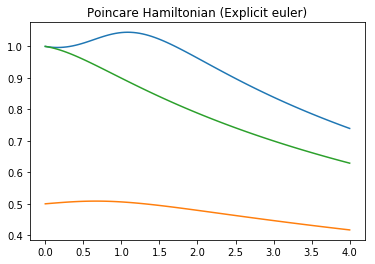

In [70]:
plt.title("Poincare Hamiltonian (Explicit euler)")
plt.plot(T,Hamiltonian(Q,P));

### 3.2 High order explicit schemes

A natural approach to improve the ODE solver is to increase its consistency order. This can be achieved using Runge-Kutta methods, here of second and fourth order.

In [71]:
def SymplecticGradient(q,p,H):
    d=len(q)
    q_ad = ad.Dense.identity(constant=q,shape_free=(d,),shift=(0,d))
    p_ad = ad.Dense.identity(constant=p,shape_free=(d,),shift=(d,0))
    grad = np.moveaxis(H(q_ad,p_ad).coef,-1,0)
    return grad[d:],-grad[:d]

def RK2Step(q,p,H,dt):
    k1 = SymplecticGradient(q,p,H)
    k2 = SymplecticGradient(q+0.5*dt*k1[0],p+0.5*dt*k1[1],H)
    return q+dt*k2[0],p+dt*k2[1]

def RK4Step(q,p,H,dt):
    k1 = SymplecticGradient(q,p,H)
    k2 = SymplecticGradient(q+0.5*dt*k1[0],p+0.5*dt*k1[1],H)
    k3 = SymplecticGradient(q+0.5*dt*k2[0],p+0.5*dt*k2[1],H)
    k4 = SymplecticGradient(q+dt*k3[0],p+dt*k3[1],H)
    return q+dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6.,p+dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6.

In [72]:
Q2,P2,T = Geodesic(q_vec,p_vec,Hamiltonian,4.,step=RK2Step)
Q2,P2 = [np.moveaxis(arr,-1,1) for arr in (Q2,P2)] 

In [73]:
Q4,P4,T = Geodesic(q_vec,p_vec,Hamiltonian,4.,step=RK4Step)
Q4,P4 = [np.moveaxis(arr,-1,1) for arr in (Q4,P4)] 

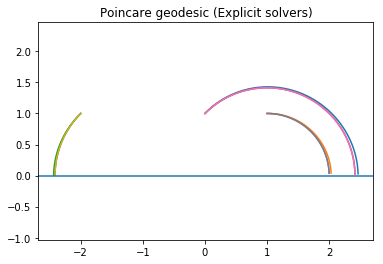

In [74]:
plt.axis('equal'); plt.title("Poincare geodesic (Explicit solvers)")
plt.plot(Q[0],Q[1], Q2[0],Q2[1], Q4[0],Q4[1]); plt.axhline(0);

In this example, the Hamiltonian is almost exactly constant for the second and fourth order models.

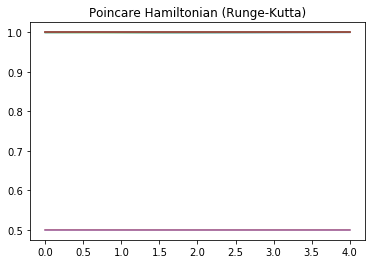

In [75]:
plt.title("Poincare Hamiltonian (Runge-Kutta)")
plt.plot(T,Hamiltonian(Q2,P2), T,Hamiltonian(Q4,P4)); #T,Hamiltonian(Q,P),

**Cone model.**
However, if the trajectory is long enough, and the time step is large enough, then even the high order models fail to conserve the Hamiltonian. This is evidenced with 

In [76]:
Hamiltonian = H_Log

In [77]:
q,p = np.array([1,0]),np.array([0,1])

In [78]:
Q,P,T = Geodesic(q,p,Hamiltonian,6.,step=EulerStep)
Q2,P2,T2 = Geodesic(q,p,Hamiltonian,25.,step=RK2Step)
Q4,P4,T4 = Geodesic(q,p,Hamiltonian,75.,step=RK4Step)

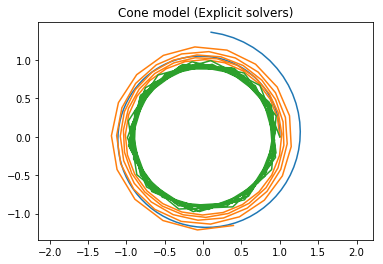

In [79]:
plt.axis('equal'); plt.title("Cone model (Explicit solvers)")
plt.plot(Q[0],Q[1], Q2[0],Q2[1], Q4[0],Q4[1]); 

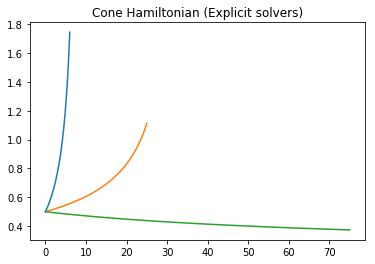

In [80]:
plt.title("Cone Hamiltonian (Explicit solvers)")
plt.plot(T,Hamiltonian(Q,P), T2,Hamiltonian(Q2,P2), T4,Hamiltonian(Q4,P4));

Likewise, in the celestial mechanics case, the Hamiltonian drifts with time using the Euler explicit and Runge-Kutta schemes.

In [81]:
Hamiltonian = H_Celestial
q,p = np.array([1.,0.]),np.array([0.3,0.7])
t = 10.
Q,P,T = Geodesic(q,p,Hamiltonian,t,step=EulerStep,n=int(100*t))
Q2,P2,T2 = Geodesic(q,p,Hamiltonian,t,step=RK2Step,n=int(20*t))
Q4,P4,T4 = Geodesic(q,p,Hamiltonian,t,step=RK4Step,n=int(8*t))

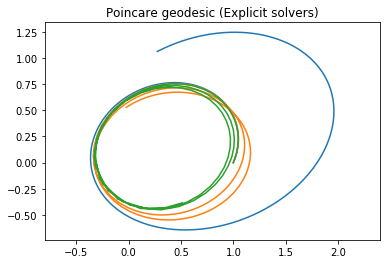

In [82]:
plt.axis('equal'); plt.title("Poincare geodesic (Explicit solvers)")
plt.plot(Q[0],Q[1], Q2[0],Q2[1], Q4[0],Q4[1]); 

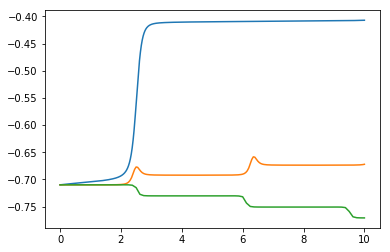

In [83]:
plt.plot(T,Hamiltonian(Q,P), T2,Hamiltonian(Q2,P2), T4,Hamiltonian(Q4,P4));

### 3.3 Symplectic Euler scheme - Separable case

Symplectic schemes guarantee that a quantity, closely related with the Hamiltonian, is conserved along the trajectory. 

The Euler symplectic scheme is defined as follows:
$$
    \frac{q_{n+1}-q_n}{\Delta t} = \partial_p H(q_n,p_n), \quad
    \frac{p_{n+1}-p_n}{\Delta t} = -\partial_q H(q_{n+1},p_{n+1}).
$$
Note that the scheme is semi-implicit, in view of the definition of $p_{n+1}$.
Two cases must be distinguished for implementation.
* **Separable Hamiltonians.** If the Hamiltonian takes the form $H(q,p) = F(p) + V(q)$, then the Euler symplectic scheme becomes explicit. The Celestial Mechanics and Lotka-Volterra schemes fall in that category.
* **Non separable Hamiltonians.** If the Hamiltonian has a general form, then one can try to solve the implicit part of Euler's symplectic scheme using a Newton method. Another approach, not detailed here, is to introduce an higher dimensional separable Hamiltonian with the same dynamics.

In [84]:
def SymplecticEulerStep_Separable(q,p,H,dt):
    d=len(q)
    
    # Differentiate w.r.t. p and advance q
    p_ad = ad.Dense.identity(constant=p,shape_free=(d,))
    p_grad = np.moveaxis(H(q,p_ad).coef,-1,0)
    q1 = q+dt*p_grad
    
    # Differentiate w.r.t. q and advance p
    q1_ad = ad.Dense.identity(constant=q1,shape_free=(d,))
    q1_grad = np.moveaxis(H(q1_ad,p).coef,-1,0) # We can use p thanks to separability
    p1 = p-dt*q1_grad
    
    return q1,p1

In [85]:
Hamiltonian = H_Celestial
q,p = np.array([1,0]),np.array([0.3,0.7])

In [86]:
t = 20.
QS,PS,TS = Geodesic(q,p,Hamiltonian,t,step=SymplecticEulerStep_Separable,n=int(30*t))

The symplectic Euler scheme is not very accurate, but it has the property that the Hamiltonian remains bounded above and below during the evolution.

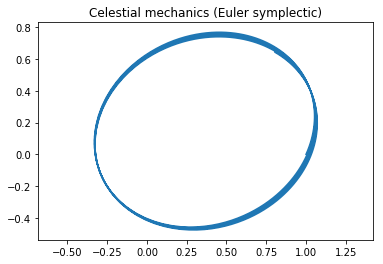

In [87]:
plt.axis('equal'); plt.title("Celestial mechanics (Euler symplectic)")
plt.plot(QS[0],QS[1]); 

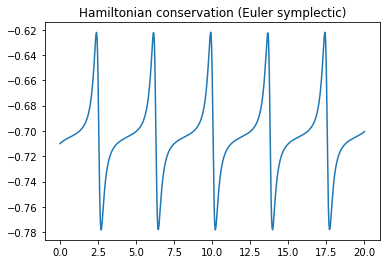

In [88]:
plt.title("Hamiltonian conservation (Euler symplectic)")
plt.plot(TS,Hamiltonian(QS,PS));

### 3.4 Symplectic Verlet scheme - Separable case

The Verlet method is a second order symplectif integration scheme. It is explicit if the Hamiltonian is separable.

In [89]:
def SymplecticVerletStep_Separable(q,p,H,dt):
    d=len(q)
    
    # Differentiate w.r.t. p and advance q
    p_ad = ad.Dense.identity(constant=p,shape_free=(d,))
    p_grad = np.moveaxis(H(q,p_ad).coef,-1,0)
    q1 = q+0.5*dt*p_grad
    
    # Differentiate w.r.t. q and advance p
    q1_ad = ad.Dense.identity(constant=q1,shape_free=(d,))
    q1_grad = np.moveaxis(H(q1_ad,p).coef,-1,0)
    p1 = p-dt*q1_grad
    
    # Differentiate w.r.t. p and advance q
    p1_ad = ad.Dense.identity(constant=p1,shape_free=(d,))
    p1_grad = np.moveaxis(H(q1,p1_ad).coef,-1,0)
    q2 = q1+0.5*dt*p1_grad
    
    return q2,p1

In [90]:
Hamiltonian = H_Celestial
q,p = np.array([1,0]),np.array([0.3,0.7])

In [91]:
t = 20.
QV,PV,TV = Geodesic(q,p,Hamiltonian,t,step=SymplecticVerletStep_Separable,n=int(30*t))

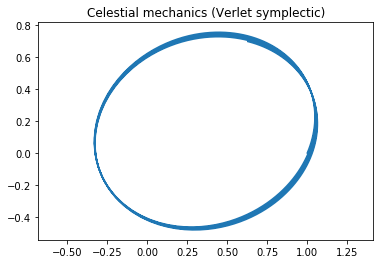

In [92]:
plt.axis('equal'); plt.title("Celestial mechanics (Verlet symplectic)")
plt.plot(QV[0],QV[1]); 

The improved accuracy is more obvious on the Hamiltonian conservation than the trajectory.

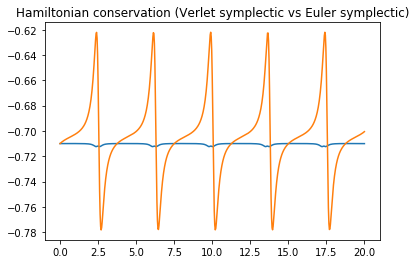

In [93]:
plt.title("Hamiltonian conservation (Verlet symplectic vs Euler symplectic)")
plt.plot(TV,Hamiltonian(QV,PV), TS,Hamiltonian(QS,PS) );

### 3.5 Symplectic Euler scheme - Non separable case

We implement the general semi-implicit Symplectic Euler scheme using a Newton method for the implicit part.
Our first step is to implement the Newton method.

In [94]:
def NewtonSolve(F,p0,niter=4,*args):
    p_ad = ad.Dense.identity(constant=p0.copy(),shape_free=(len(p0),))
    for i in range(niter):
        p_ad = p_ad+F(p_ad,*args).solve()
    return p_ad.value

We test it by solving $x+x^2=0$, with initial guess $x=0.5$. The solution $x=0$ is found.

In [95]:
def FTest(x):
    return x+x**2
NewtonSolve(FTest,np.array([0.5]))

array([2.32305737e-08])

However, compatibility issues may arise if the function called $F$ itself uses automatic differentiation. We circumvent this potential problem  by hiding the AD information in the element type.

In [96]:
def NewtonSolve_AD(F,p0,niter=4,*args):
    d=len(p0)
    def disac(x): return ad.disassociate(x,shape_free=(d,))
    def assoc(x): return ad.associate(x)
    p_ad = ad.Dense.identity(constant=p0.copy(),shape_free=(d,))
    for i in range(niter):
        p_ad = p_ad+assoc(F(disac(p_ad),*args)).solve()
    return p_ad.value

In [97]:
def SymplecticEulerStep(q0,p0,H,dt):
    d=len(q0)
    p0_ad = ad.Dense.identity(constant=p0,shape_free=(d,))
    p0_grad = np.moveaxis(H(q0,p0_ad).coef,-1,0)
    q1=q0+dt*p0_grad
    
    def F(p1):
        nonlocal q1,p0,dt
        # A potential issue is that p1 may have an additional singleton dimension,
        # which is introduced in recursive AD techniques. So we must reshape q1 and p0 accordingly.
        q1_,p0_= (a.reshape(p1.shape) for a in (q1,p0))    
        
        q1_ad = ad.Dense.identity(constant=q1_,shape_free=(d,))
        q1_grad = np.moveaxis(H(q1_ad,p1).coef,-1,0)
        result = p1-p0_+dt*q1_grad

        return result
    return q1,NewtonSolve_AD(F,p0)

If the Hamiltonian is separable, then the semi-implicit scheme coincides with the explicit scheme.

In [98]:
Hamiltonian = H_Celestial
q,p = np.array([1,0]),np.array([0.3,0.7])
print("Semi-implicit :", SymplecticEulerStep(q,p,Hamiltonian,0.1))
print("Explicit      :", SymplecticEulerStep_Separable(q,p,Hamiltonian,0.1))

Semi-implicit : (array([1.03, 0.07]), array([0.2063897 , 0.69363813]))
Explicit      : (array([1.03, 0.07]), array([0.2063897 , 0.69363813]))


However, only the semi-implicit implementation is truly symplectic for general hamiltonians.

In [99]:
Hamiltonian = H_Log
q,p = np.array([1,0]),np.array([0,1])
print("Semi-implicit :", SymplecticEulerStep(q,p,Hamiltonian,0.1))
print("Explicit      :", SymplecticEulerStep_Separable(q,p,Hamiltonian,0.1))

Semi-implicit : (array([1. , 0.1]), array([-0.0990099 ,  0.99009901]))
Explicit      : (array([1. , 0.1]), array([-0.1 ,  0.99]))


In [100]:
t = 20.
QI,PI,TI = Geodesic(q,p,Hamiltonian,t,step=SymplecticEulerStep,n=int(10*t))
QS,PS,TS = Geodesic(q,p,Hamiltonian,t,step=SymplecticEulerStep_Separable,n=int(10*t))

None of the two schemes is very accurate, since they are only first order. (In this specific example, one expects a closed geodesic.)

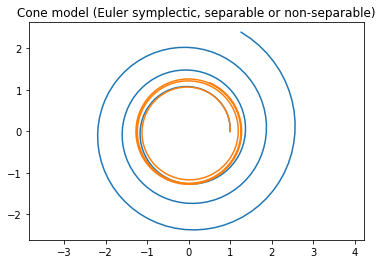

In [101]:
plt.axis('equal'); plt.title("Cone model (Euler symplectic, separable or non-separable)")
plt.plot(QI[0],QI[1], QS[0],QS[1] ); 

The semi-implicit scheme perfectly conserves the Hamiltonian. This is in contrast with the explicit scheme which here makes the invalid assumption of separability. The goal is achieved.

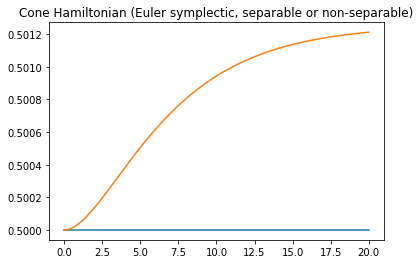

In [102]:
plt.title("Cone Hamiltonian (Euler symplectic, separable or non-separable)")
plt.plot(TI,Hamiltonian(QI,PI), TS,Hamiltonian(QS,PS));

## 4. Shooting geodesics

Geodesic shooting is the process of adjusting the initial velocity or momentum of a geodesic, so that the endpoint at time $t=1$ meets a prescribed position. 
A natural strategy is to optimize the initial velocity using a Newton method, taking advantage of automatic differentiation to compute the jacobian matrix of the exponential map. Note that AD is also used, independently, to solve Hamilton's ODE, which involves the derivatives of the Hamiltonian.

We use the Poincare Half-Plane model for illustration. It is particularly simple since, due to its hyperbolic nature, there exists a unique geodesic between any two given points.

**Riemannian exponential map.** In Riemannian geometry, the exponential map associates to a position $q$ and velocity $v$ the endpoint $\exp_x(v) := \gamma_x^v(1)$ of the corresponding geodesic $\gamma_x^v$. The inverse map is known as the logarithmic map. This terminology does not perfectly apply here since Hamilton's equations are written in terms of the Hamiltonian momentum, which is *dual* to the velocity.

In [103]:
def Shoot(q,p,*args,**kwargs):
    Q,P,T = Geodesic(q,p,*args,**kwargs)
    return np.take(Q,-1,axis=-1)

In [104]:
q0,p0=np.array([0,1]),np.array([1,1])
Shoot(q0,p0,H_HalfPlane,1.,step=EulerStep,n=10)

array([1.7200162 , 1.27931064])

In [105]:
def Aim(q1,q0,pGuess,*args,**kwargs):
    if pGuess is None: pGuess=np.zeros(q0.shape)
    def F(p): 
        nonlocal args,kwargs,q0,q1
        # Reshape needed due to introduced trailing singleton 
        q0_,q1_ = (np.reshape(a,p.shape) for a in (q0,q1))
        return Shoot(q0_,p,*args,**kwargs)-q1_
    return NewtonSolve_AD(F,pGuess)

In [106]:
q1 = np.array([1,1])
p01 = Aim(q1,q0,p0,H_HalfPlane,1.,step=EulerStep,n=10)

In [107]:
Shoot(q0,p01,H_HalfPlane,1.,step=EulerStep,n=10)

array([1., 1.])